## 1.导入数据，观察数据分布

C:\Users\19464\AppData\Local\Temp\ipykernel_13876\1461963000.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


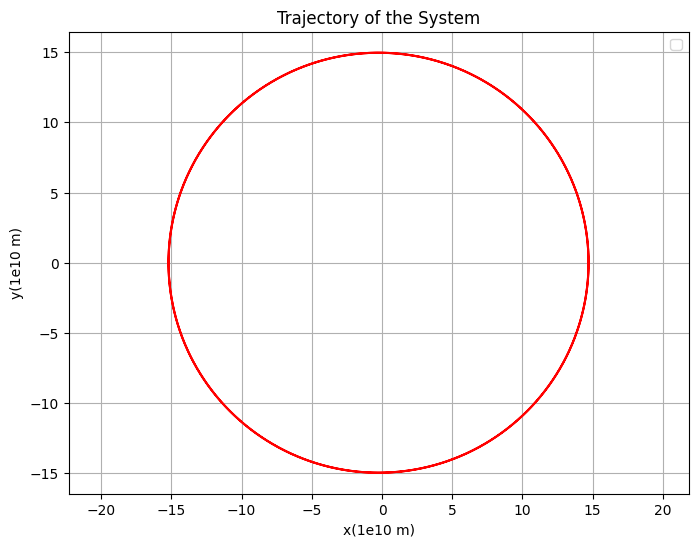

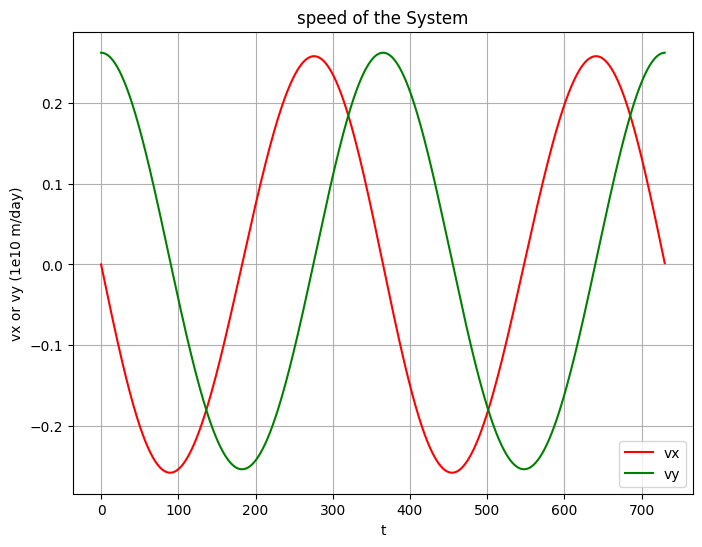

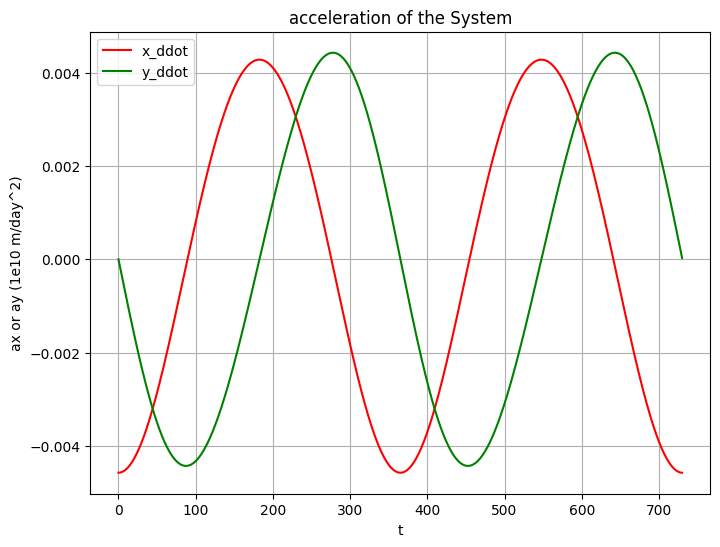

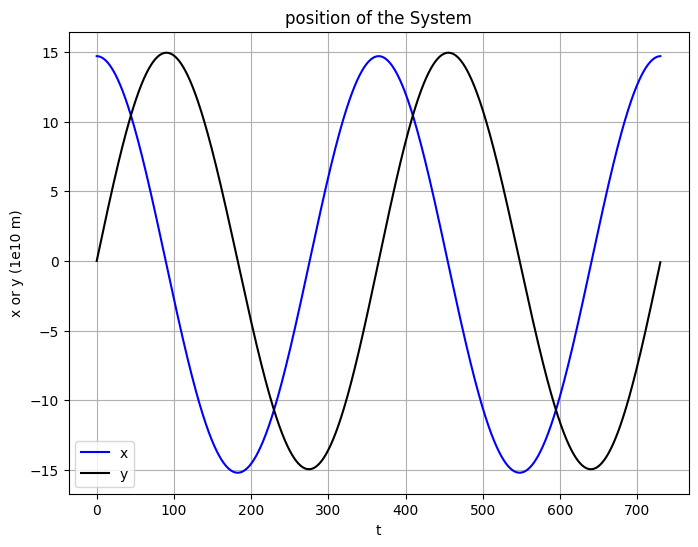

In [21]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt

# 1. 数据读取和预处理
# 加载数据
df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]
yy = array[1:]

# 提取坐标和速度，注意单位一致
x , y, vx, vy = yy[0]/1e10, yy[1]/1e10,  yy[2]/1e10,  yy[3]/1e10

# 计算距离 r 和加速度分量
r = np.sqrt(x**2 + y**2)
G = 6.67430e-11 * 86400**2/1e30  # 引力常数, m^3 kg^-1 s^-2（调整单位）
M = 1.989e30  # 太阳质量
GM = G * M

# 加速度分量
x_ddot = -GM * x / r**3
y_ddot = -GM * y / r**3

plt.figure(figsize=(8, 6))
plt.plot(x,y, color = 'red')
plt.xlabel('x(1e10 m)')
plt.ylabel('y(1e10 m)')
plt.title('Trajectory of the System')
plt.legend()
plt.grid()
plt.axis('equal')  # 确保 x 和 y 轴比例相同
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t,vx, color = 'red',label = 'vx')
plt.plot(t,vy, color = 'green',label = 'vy')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/day)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t,x_ddot, color = 'red',label = 'x_ddot')
plt.plot(t,y_ddot, color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t,x, color = 'blue',label = 'x')
plt.plot(t,y, color = 'black',label = 'y')
plt.xlabel('t')
plt.ylabel('x or y (1e10 m)')
plt.title('position of the System')
plt.legend()
plt.grid()
plt.show()


## 2.将数据标准化，观察数据分布

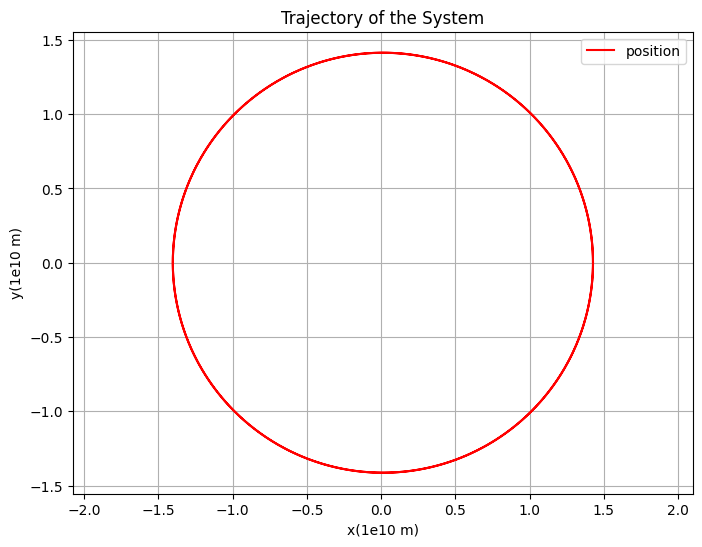

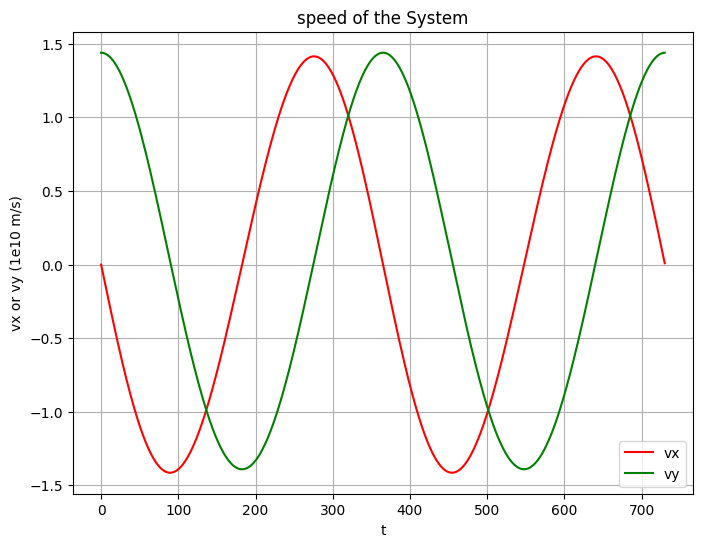

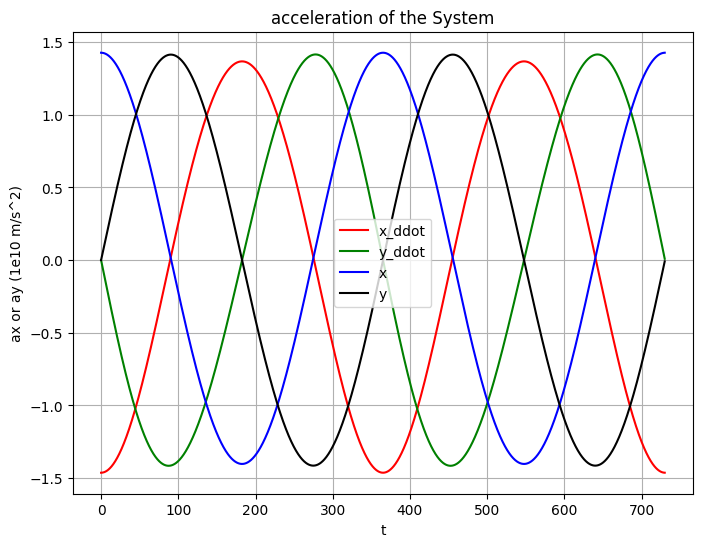

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1,1))
y_scaled = scaler.fit_transform(y.reshape(-1,1))
vx_scaled = scaler.fit_transform(vx.reshape(-1,1))
vy_scaled = scaler.fit_transform(vy.reshape(-1,1))
ax_scaled = scaler.fit_transform(x_ddot.reshape(-1,1))
ay_scaled = scaler.fit_transform(y_ddot.reshape(-1,1))

plt.figure(figsize=(8, 6))
plt.plot(x_scaled,y_scaled, color = 'red',label = 'position')
plt.xlabel('x(1e10 m)')
plt.ylabel('y(1e10 m)')
plt.title('Trajectory of the System')
plt.legend()
plt.grid()
plt.axis('equal')  # 确保 x 和 y 轴比例相同
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t,vx_scaled, color = 'red', label = 'vx')
plt.plot(t,vy_scaled, color = 'green', label = 'vy')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/s)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t,ax_scaled, color = 'red', label = 'x_ddot')
plt.plot(t,ay_scaled, color = 'green', label = 'y_ddot')
plt.plot(t,x_scaled, color = 'blue', label = 'x')
plt.plot(t,y_scaled, color = 'black', label = 'y')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/s^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()

## 3.使用LASSO回归

In [23]:
import numpy as np

# 假设我们有 n 个时间点的观测数据 (x, y)
n = t.size  # 时间点数量

# 定义候选基函数
def build_design_matrix(x,y):
    # 计算分母项
    denominator = (x**2 + y**2)**(3/2)
    
    # 构建设计矩阵
    Theta = np.column_stack([
        np.ones(n),  # 常数项
        x,           # x
        y,           # y
        x**2,        # x^2
        y**2,        # y^2
        x * y,       # x * y
        x / denominator,  # x / (x^2 + y^2)^(3/2)
        y / denominator   # y / (x^2 + y^2)^(3/2)
    ])
    return Theta

# 构建生成矩阵
Theta = build_design_matrix(x_scaled, y_scaled)

# 输出生成矩阵的前 5 行
print("Design matrix (first 5 rows):")
print(Theta[:5])

Design matrix (first 5 rows):
[[ 1.00000000e+00  1.42687737e+00 -1.58684838e-06  2.03597902e+00
   2.51808779e-12 -2.26423804e-06  4.91164197e-01 -5.46229922e-07]
 [ 1.00000000e+00  1.42687586e+00  2.06033912e-03  2.03597473e+00
   4.24499730e-06  2.93984816e-03  4.91163697e-01  7.09216413e-04]
 [ 1.00000000e+00  1.42687135e+00  4.12226064e-03  2.03596185e+00
   1.69930327e-05  5.88193560e-03  4.91162190e-01  1.41897766e-03]
 [ 1.00000000e+00  1.42686383e+00  6.18417323e-03  2.03594039e+00
   3.82439985e-05  8.82397310e-03  4.91159678e-01  2.12873609e-03]
 [ 1.00000000e+00  1.42685330e+00  8.24607245e-03  2.03591034e+00
   6.79977108e-05  1.17659357e-02  4.91156159e-01  2.83849031e-03]]


In [24]:
from sklearn.linear_model import Lasso, LinearRegression

# 假设我们有二阶导数数据 (x_ddot, y_ddot)
#x_ddot = ax_scaled
#y_ddot = ay_scaled


# 使用 LASSO 回归
lasso = Lasso(alpha=0.1)  # alpha 是正则化参数
lasso.fit(Theta, ax_scaled)   # 拟合 x_ddot
coefficients_x_lasso = lasso.coef_

lasso.fit(Theta, ay_scaled)   # 拟合 y_ddot
coefficients_y_lasso = lasso.coef_

# 输出 Lasso 回归的系数
print("Lasso Coefficients for ax:")
print(coefficients_x_lasso)

print("\nLasso Coefficients for ay:")
print(coefficients_y_lasso)

# 第二步：去除正则化项，重新计算参数

# 获取Lasso模型中非零的系数索引
nonzero_indices_x = np.where(coefficients_x_lasso != 0)[0]
nonzero_indices_y = np.where(coefficients_y_lasso != 0)[0]

# 筛选出在Lasso中非零的特征
Theta_x = Theta[:, nonzero_indices_x]
Theta_y = Theta[:, nonzero_indices_y]

# 使用 OLS 进行重新拟合，去除正则化项
ols_x = LinearRegression()
ols_x.fit(Theta_x, ax_scaled)
coefficients_x_ols = ols_x.coef_

ols_y = LinearRegression()
ols_y.fit(Theta_y, ay_scaled)
coefficients_y_ols = ols_y.coef_

# 输出 OLS 回归的系数
print("\nOLS Coefficients for ax (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_x_ols = np.zeros(Theta.shape[1])
full_coefficients_x_ols[nonzero_indices_x] = coefficients_x_ols
print(full_coefficients_x_ols)

print("\nOLS Coefficients for ay (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_y_ols = np.zeros(Theta.shape[1])
full_coefficients_y_ols[nonzero_indices_y] = coefficients_y_ols
print(full_coefficients_y_ols)

Lasso Coefficients for ax:
[ 0.         -0.89968821 -0.         -0.          0.         -0.
 -0.         -0.        ]

Lasso Coefficients for ay:
[ 0.        -0.        -0.8996882 -0.         0.        -0.
 -0.        -0.       ]

OLS Coefficients for ax (after removing regularization):
[ 0.         -0.99968821  0.          0.          0.          0.
  0.          0.        ]

OLS Coefficients for ay (after removing regularization):
[ 0.         0.        -0.9996882  0.         0.         0.
  0.         0.       ]


#### 问题分析：为什么找的是x和y，而不是目标式子呢？
1.本质上，椭圆方程为
$$
x = a sin(t)\\
y = b cos(t)
$$
速度为一阶导，加速度为二阶导
$$
vx = acos(t),     vy = -bsin(t)\\
ax = -asin(t)，   ay = -bcos(t)
$$
当数据标准化后，显然的有$ax =-x, ay = -y$

## 4.根据问题分析，不能采取标准化的数据，而应该保留数据的大小特征。

In [25]:
import numpy as np

# 假设我们有 n 个时间点的观测数据 (x, y)
n = t.size  # 时间点数量

# 定义候选基函数
def build_design_matrix(x, y):
    # 计算分母项
    denominator = (x**2 + y**2)**(3/2)
    
    # 构建设计矩阵
    Theta = np.column_stack([
        np.ones(n),  # 常数项
        x,           # x
        y,           # y
        x**2,        # x^2
        y**2,        # y^2
        x * y,       # x * y
        x / denominator,  # x / (x^2 + y^2)^(3/2)
        y / denominator   # y / (x^2 + y^2)^(3/2)
    ])
    return Theta

# 构建生成矩阵
Theta = build_design_matrix(x, y)

# 输出生成矩阵的前 5 行
print("Design matrix (first 5 rows):")
print(Theta[:5])

Design matrix (first 5 rows):
[[1.00000000e+00 1.47100000e+01 0.00000000e+00 2.16384100e+02
  0.00000000e+00 0.00000000e+00 4.62141165e-03 0.00000000e+00]
 [1.00000000e+00 1.47099841e+01 2.18112820e-02 2.16383632e+02
  4.75732023e-04 3.20843611e-01 4.62140640e-03 6.85240702e-06]
 [1.00000000e+00 1.47099364e+01 4.36225169e-02 2.16382228e+02
  1.90292398e-03 6.41684448e-01 4.62139066e-03 1.37047970e-05]
 [1.00000000e+00 1.47098569e+01 6.54336574e-02 2.16379889e+02
  4.28156352e-03 9.62519733e-01 4.62136443e-03 2.05571529e-05]
 [1.00000000e+00 1.47097455e+01 8.72446564e-02 2.16376613e+02
  7.61163006e-03 1.28334669e+00 4.62132770e-03 2.74094577e-05]]


In [28]:
from sklearn.linear_model import Lasso

# 使用 LASSO 回归
lasso = Lasso(alpha=0.001,max_iter=3000)  # alpha 是正则化参数
lasso.fit(Theta, x_ddot)   # 拟合 x_ddot
coefficients_x = lasso.coef_

lasso.fit(Theta, y_ddot)   # 拟合 y_ddot
coefficients_y = lasso.coef_

# 输出回归系数
print("Coefficients for x_ddot:")
print(coefficients_x)

print("\nCoefficients for y_ddot:")
print(coefficients_y)

# 获取Lasso模型中非零的系数索引
nonzero_indices_x = np.where(coefficients_x_lasso != 0)[0]
nonzero_indices_y = np.where(coefficients_y_lasso != 0)[0]

# 筛选出在Lasso中非零的特征
Theta_x = Theta[:, nonzero_indices_x]
Theta_y = Theta[:, nonzero_indices_y]

# 使用 OLS 进行重新拟合，去除正则化项
ols_x = LinearRegression()
ols_x.fit(Theta_x, x_ddot)
coefficients_x_ols = ols_x.coef_

ols_y = LinearRegression()
ols_y.fit(Theta_y, y_ddot)
coefficients_y_ols = ols_y.coef_

# 输出 OLS 回归的系数
print("\nOLS Coefficients for ax (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_x_ols = np.zeros(Theta.shape[1])
full_coefficients_x_ols[nonzero_indices_x] = coefficients_x_ols
print(full_coefficients_x_ols)

print("\nOLS Coefficients for ay (after removing regularization):")
# 为了便于比较，显示与原始特征对应的OLS系数
full_coefficients_y_ols = np.zeros(Theta.shape[1])
full_coefficients_y_ols[nonzero_indices_y] = coefficients_y_ols
print(full_coefficients_y_ols)

Coefficients for x_ddot:
[ 0.00000000e+00 -2.87213456e-04 -0.00000000e+00 -0.00000000e+00
  8.18141954e-07 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]

Coefficients for y_ddot:
[ 0.00000000e+00 -0.00000000e+00 -2.87411578e-04 -0.00000000e+00
  0.00000000e+00 -7.79248968e-07 -0.00000000e+00 -0.00000000e+00]

OLS Coefficients for ax (after removing regularization):
[ 0.        -0.0002961  0.         0.         0.         0.
  0.         0.       ]

OLS Coefficients for ay (after removing regularization):
[ 0.          0.         -0.00029611  0.          0.          0.
  0.          0.        ]


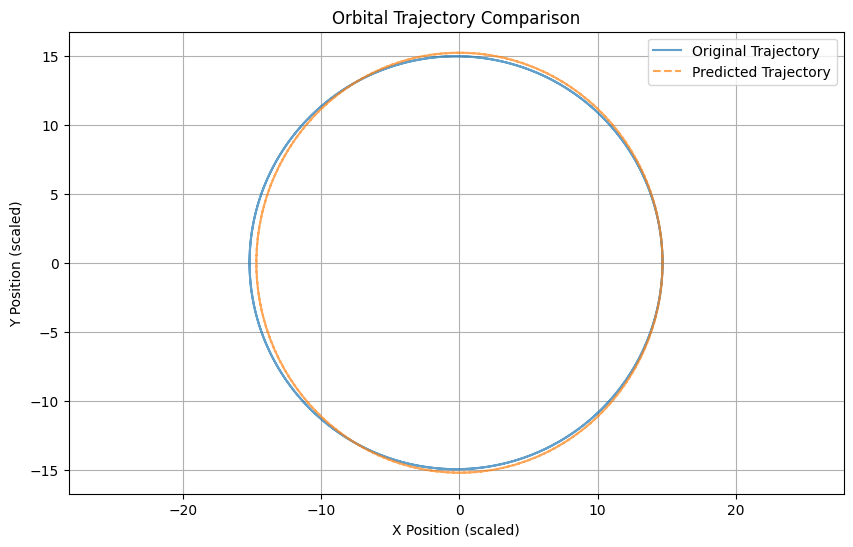

In [30]:
from scipy.integrate import solve_ivp

# 定义微分方程，用于描述系统的动力学行为
def orbital_dynamics(t, state, coefficients_x, coefficients_y):
    x, y, vx, vy = state
    # 构建当前状态对应的设计矩阵行
    current_Theta = np.array([
        1,
        x,
        y,
        x**2,
        y**2,
        x * y,
        x / (x**2 + y**2)**(3/2) if x**2 + y**2 != 0 else 0,
        y / (x**2 + y**2)**(3/2) if x**2 + y**2 != 0 else 0
    ])
    # 使用 LASSO 回归的系数计算加速度
    ax = np.dot(coefficients_x, current_Theta)
    ay = np.dot(coefficients_y, current_Theta)
    return [vx, vy, ax, ay]

# 初始化状态向量 [x0, y0, vx0, vy0]
initial_state = [x[0], y[0], vx[0], vy[0]]

# 使用积分器生成轨迹
t_span = (t[0], t[-1])  # 时间范围
t_eval = t  # 需要评估的时间点
solution = solve_ivp(
    orbital_dynamics,
    t_span,
    initial_state,
    args=(full_coefficients_x_ols, full_coefficients_y_ols),
    t_eval=t_eval,
    method='RK45'
)

# 提取轨迹结果
x_pred = solution.y[0]
y_pred = solution.y[1]

# 生成轨迹图
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original Trajectory', alpha=0.7)
plt.plot(x_pred, y_pred, label='Predicted Trajectory', linestyle='--', alpha=0.7)
plt.title("Orbital Trajectory Comparison")
plt.xlabel("X Position (scaled)")
plt.ylabel("Y Position (scaled)")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show() 
